In [151]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from datetime import datetime

from IPython.display import display, HTML
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [153]:
## Local Utils File
from utils.eda import *
from utils.utils import *
from utils.melissa_utils import *
from utils.Bhushan_utils import *
from utils.lta_omv_scraper import *

## Feature Processing

### Test Data preview

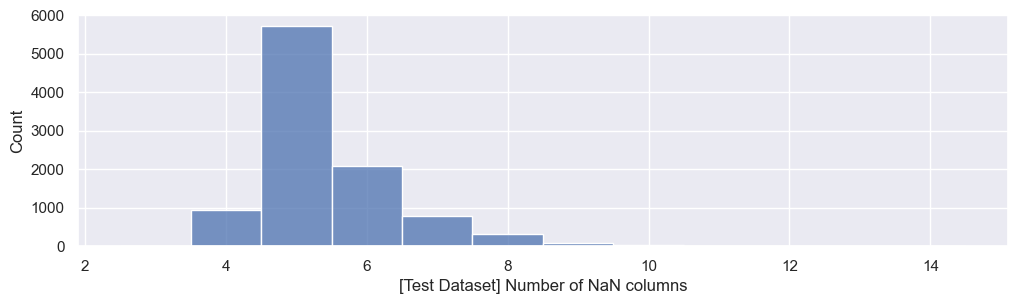

In [154]:
test_df = pd.read_csv(r"./dataset/test.csv")

plt.rcParams['figure.figsize'] = (12, 3)
sns.set()

number_nans = test_df.apply(lambda row: sum(map(isnan, row)), axis=1)
sns.histplot(number_nans, discrete=True)
plt.xlabel('[Test Dataset] Number of NaN columns')
plt.show()

### Read and clean dataset

In [130]:
train_df = pd.read_csv(r"./dataset/train.csv")

# clean model
train_df['model'] = train_df['model'].apply(lambda x:x.replace('(', ''))
train_df['reg_date_dt'] = train_df['reg_date'].apply(lambda x: datetime.strptime(x, "%d-%b-%Y"))
train_df['reg_date_year'] = train_df['reg_date_dt'].apply(lambda x:x.year)
train_df['reg_date_month'] = train_df['reg_date_dt'].apply(lambda x:x.month)

# Adding additional feature for imputation later
train_df["model_make"] = train_df.model + "_" + train_df.make

General overview of Nan Columns

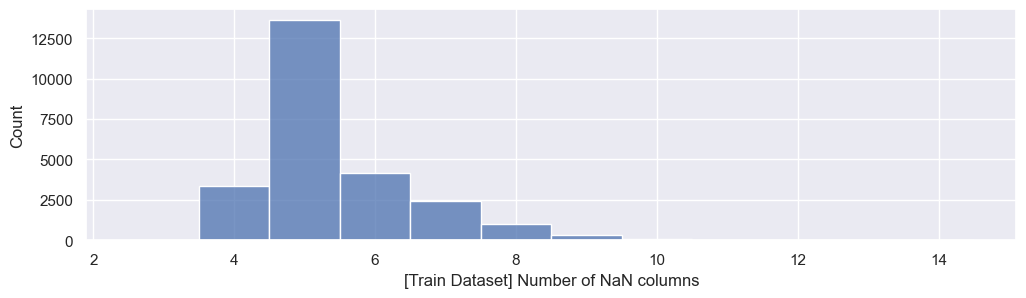

In [136]:
plt.rcParams['figure.figsize'] = (12, 3)
sns.set()

number_nans = train_df.apply(lambda row: sum(map(isnan, row)), axis=1)
sns.histplot(number_nans, discrete=True)
plt.xlabel('[Train Dataset] Number of NaN columns')
plt.show()

In [58]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   listing_id         25000 non-null  int64         
 1   title              25000 non-null  object        
 2   make               23684 non-null  object        
 3   model              25000 non-null  object        
 4   description        24320 non-null  object        
 5   manufactured       24993 non-null  float64       
 6   original_reg_date  255 non-null    object        
 7   reg_date           25000 non-null  object        
 8   type_of_vehicle    25000 non-null  object        
 9   category           25000 non-null  object        
 10  transmission       25000 non-null  object        
 11  curb_weight        24693 non-null  float64       
 12  power              22360 non-null  float64       
 13  fuel_type          5879 non-null   object        
 14  engine

### Fill missing 'make' info from title

In [7]:
make_ls = train_df['make'].dropna().unique()
compiled_regex = compile_make_pattern(make_ls)

train_df = apply_make_extraction(train_df, compiled_regex)

In [8]:
train_df['make'] = train_df['make'].fillna(train_df['extracted_make'])


In [61]:
train_df["model_make"] = train_df.model + "_" + train_df.make

### type_of_vehicle

In [79]:
# For each model and make check the type of vehicles count
unique_list = display_feature_dist_by_ref_col(df=train_df,feature="type_of_vehicle",ref="model_make")
make_models_with_diff_bodies = list()
for key, value in unique_list.items():
    if len(value) >= 2:
        make_models_with_diff_bodies.append(key)

Number of model_make unable to be inputted 0


In [141]:
# Assuming you have a DataFrame 'train_df' with columns 'type_of_vehicle' and 'price'
fig = px.box(train_df, x="type_of_vehicle", y='price', points="all")

# Update the layout to make the x-axis labels horizontal
fig.update_layout(xaxis_tickangle=0)

# Show the figure
fig.show()

In [150]:
# Assuming you have a DataFrame 'train_df' with columns 'type_of_vehicle' and 'price'
fig = px.scatter(train_df, x="omv", y='price', color="type_of_vehicle",trendline="ols")

# Show the figure
fig.show()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [156]:
## Processing 
train_encoded = generic_one_hotencoding(train_df, "type_of_vehicle")
display(train_encoded)

listing_id                                              title  \
0         1292132  Land Rover Range Rover Velar 3.0A Si6 R-Dynami...   
1         1294696   Mercedes-Benz C-Class C200 Sport Premium Sunroof   
2         1311717              Honda Odyssey 2.4A (COE till 09/2027)   
3         1310068       Toyota Corolla Altis 1.6A (COE till 12/2028)   
4         1325280                     Lexus GS300 (COE till 06/2026)   
...           ...                                                ...   
24995     1329201      Mercedes-Benz C-Class C180 (COE till 06/2031)   
24996     1285898                           Bentley Bentayga 4.0A V8   
24997     1306309                         Mercedes-Benz A-Class A180   
24998     1306902               Audi A3 Sportback 1.0A TFSI S-tronic   
24999     1124035                    BMW 2 Series 220i Coupe Sunroof   

                make     model  \
0         land rover     range   
1      mercedes-benz      c200   
2              honda   odyssey   
3             toyota     altis   
4              lexus        gs   
...              ...       ...   
24995  mercedes-benz      c180   
24996        bentley  bentayga   
24997  mercedes-benz      a180   
24998           audi        a3   
24999            bmw      220i   

                                             description  manufactured  \
0      1 owner, no repairs needed! it looks great, in...        2018.0   
1      rare beautiful white c200 sport premium sunroo...        2017.0   
2                comes with warranty. full service done.        2007.0   
3                                                      0        2008.0   
4      wear and tear done up. well maintained and reg...        2006.0   
...                                                  ...           ...   
24995  elegant looking and very well maintained by ow...        2011.0   
24996  ceo car chauffeur driven, always sheltered par...        2018.0   
24997  great for short term drive or to renew coe. op...        2014.0   
24998  sporty audi a3 in town with upgraded coil over...        2017.0   
24999  flexible in house loan package and bank loan a...        2016.0   

      original_reg_date     reg_date  type_of_vehicle  \
0                   NaN  08-mar-2018              suv   
1                   NaN  28-dec-2017     luxury sedan   
2                   NaN  19-sep-2007              mpv   
3                   NaN  15-dec-2008  mid-sized sedan   
4                   NaN  22-dec-2006     luxury sedan   
...                 ...          ...              ...   
24995               NaN  14-jul-2011     luxury sedan   
24996       23-aug-2018  29-apr-2020              suv   
24997               NaN  01-apr-2015        hatchback   
24998               NaN  30-jun-2017        hatchback   
24999               NaN  07-dec-2016       sports car   

                                                category  ...  \
0                                               parf car  ...   
1                               parf car, premium ad car  ...   
2               coe car, premium ad car, low mileage car  ...   
3                                coe car, premium ad car  ...   
4                                coe car, premium ad car  ...   
...                                                  ...  ...   
24995           coe car, premium ad car, low mileage car  ...   
24996         parf car, direct owner sale, rare & exotic  ...   
24997  parf car, premium ad car, low mileage car, sgc...  ...   
24998                                           parf car  ...   
24999                           parf car, premium ad car  ...   

      type_of_vehicle_hatchback  type_of_vehicle_luxury sedan  \
0                           0.0                           0.0   
1                           0.0                           1.0   
2                           0.0                           0.0   
3                           0.0                           0.0   
4                           0.0                      

### curb_weight

In [63]:
# display(HTML(train_df.head(50).to_html()))

In [66]:
def fill_column_b_with_mean(df, column_a, column_b):
    # Calculate the mean of column B grouped by column A
    values = df.groupby(column_a)[column_b].agg(["mean"]).rename(columns={"mean": column_b})[column_b]
    
    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # If column B is NaN, fill it with the mean value of column B for the corresponding value in column A
        if pd.isna(row[column_b]):
            df.at[index, column_b] = values[row[column_a]]
    return df

In [67]:
feature = "curb_weight"
ref_col = "model_make"
new_df = fill_column_b_with_mean(train_df,ref_col,feature)
train_df['curb_weight_impute'] = new_df[feature]

### power 

In [68]:
feature = "power"
ref_col = "model_make"
new_df = fill_column_b_with_mean(train_df,ref_col,feature)
train_df['power_impute'] = new_df[feature]

### engine_cap 

In [69]:
feature = "engine_cap"
ref_col = "model_make"
new_df = fill_column_b_with_mean(train_df,ref_col,feature)
train_df['engine_cap_impute'] = new_df[feature]

### no_of_owners

In [37]:
display(f' Before imputation : {train_df["no_of_owners"].isna().sum()}')
# Original Code Output
rows = train_df[train_df["no_of_owners"].isna()].index

for r in rows:
    row = train_df.iloc[r]

    #Impute number of owners based on reg_date
    regDate = row["reg_date"]
    months = calculate_date_diff(regDate)

    # We estimate the number of owners based on every 3 years or 36 months
    estimated_owners = math.ceil(months / 36)
    train_df.loc[r, "no_of_owners"] = estimated_owners

display(f' After imputation : {train_df["no_of_owners"].isna().sum()}')

' Before imputation : 18'

' After imputation : 0'

In [50]:
display(f' Before imputation : {train_df["no_of_owners"].isna().sum()}')
# Function form
train_df = impute_owner_number(train_df)

display(f' After imputation : {train_df["no_of_owners"].isna().sum()}')

' Before imputation : 18'

' After imputation : 0'

### Manufactured

In [ ]:
# Manufactured

train_df['effective_reg_date'] = train_df['original_reg_date'].fillna(train_df['reg_date'])
train_df = train_df.drop(columns=['original_reg_date', 'reg_date'])

train_df['effective_reg_date'] = pd.to_datetime(train_df['effective_reg_date'], errors='coerce', format='%d-%b-%Y')
train_df['manufactured'] = train_df['manufactured'].fillna(train_df['effective_reg_date'].dt.year)

### depreciation 

In [ ]:
# Depreciation

# Vehicle age calculation
train_df = calc_vehicle_age(train_df)

# Depreciation imputation
avg_depreciation_rate_wo_age = calculate_depreciation_rate_without_age(train_df)
avg_depreciation_rate_with_age = calculate_depreciation_rate_with_age(train_df)
train_df = impute_depreciation(train_df, avg_depreciation_rate_wo_age, avg_depreciation_rate_with_age)

# Min-max normalization
train_df['depreciation'] = (train_df['depreciation'] - train_df['depreciation'].min()) / (train_df['depreciation'].max() - train_df['depreciation'].min())

### Transmission

In [ ]:
# Transmission

# One-hot encoding
train_df = pd.get_dummies(train_df, columns=['transmission'], prefix='transmission')
train_df.drop('transmission_manual', axis=1, inplace=True)

unique_transmissions = train_df['transmission_auto'].unique()
transmission_counts = train_df['transmission_auto'].value_counts()
print(unique_transmissions, transmission_counts)

### dereg_value

### mileage   

In [51]:
display(f' Before imputation : {train_df["mileage"].isna().sum()}')
# Original Code Output
rows = train_df[train_df["mileage"].isna()].index
for r in rows:
    row = train_df.iloc[r]
    #print(f"row: {row}")
    regDate = row["reg_date"]
    months = calculate_date_diff(regDate)

    #impute mileage based on reg_date 
    #we estimate that the average mileage of a car is 8000 miles per year
    estimated_mileage = months / 12 * 8000
    train_df.loc[r, "mileage"] = estimated_mileage

display(f' After imputation : {train_df["mileage"].isna().sum()}')

' Before imputation : 5304'

' After imputation : 0'

In [56]:
display(f' Before imputation : {train_df["mileage"].isna().sum()}')
# Functional Form
impute_mileage(train_df)

display(f' After imputation : {train_df["mileage"].isna().sum()}')

' Before imputation : 5304'

' After imputation : 0'

### omv 

In [70]:
result_ls = get_lta_omv_data(2002, 2025)
df_lta_car_data = preprocess_lta_omv_data(result_ls)

In [71]:
def impute_using_lta_data(row):
    # print(row)
    if not np.isnan(row['omv']):
        return row['omv']
    else:
        make = row['make']
        model = row['model']
        year = row['reg_date_year']
        lookup_by_make_model_year = df_lta_car_data[(df_lta_car_data['make_clean'] == make) & (df_lta_car_data['model_split'].str.contains(model)) & (df_lta_car_data['year'] == year)]
        
        lookup_by_make_model = df_lta_car_data[(df_lta_car_data['make_clean'] == make) & (df_lta_car_data['model_split'].str.contains(model))]

        lookup_by_make = df_lta_car_data[(df_lta_car_data['make_clean'] == make)]
        
        if not lookup_by_make_model_year.empty:
            # print('lookup_by_make_model_year')
            return lookup_by_make_model_year['omv_clean'].mean()
        elif not lookup_by_make_model.empty:
            # print('lookup_by_make_model')
            return lookup_by_make_model['omv_clean'].mean()
        elif not lookup_by_make.empty:
            # print('lookup_by_make')
            return lookup_by_make['omv_clean'].mean()
        else: 
            return None

In [72]:
train_df['omv_new'] = train_df['omv']
train_df['omv_new'] = train_df.apply(impute_using_lta_data, axis=1)
train_df['omv_new'] = train_df['omv_new'].fillna(train_df['omv_new'].mean())

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   listing_id          25000 non-null  int64         
 1   title               25000 non-null  object        
 2   make                25000 non-null  object        
 3   model               25000 non-null  object        
 4   description         24320 non-null  object        
 5   manufactured        24993 non-null  float64       
 6   original_reg_date   255 non-null    object        
 7   reg_date            25000 non-null  object        
 8   type_of_vehicle     25000 non-null  object        
 9   category            25000 non-null  object        
 10  transmission        25000 non-null  object        
 11  curb_weight         24906 non-null  float64       
 12  power               23113 non-null  float64       
 13  fuel_type           5879 non-null   object    

### Lifespan

In [64]:
display(f' Before imputation : {train_df["lifespan"].isna().sum()}')

# Functional Form
impute_lifespan(train_df)

display(f' After imputation : {train_df["lifespan"].isna().sum()}')

' Before imputation : 22671'

len of lifespan na: 22671


' After imputation : 0'

### Fuel Type

In [111]:
# Assuming you have a DataFrame 'train_df' with columns 'type_of_vehicle' and 'price'
fig = px.box(train_df, x="fuel_type", y='price', points="all")

# Update the layout to make the x-axis labels horizontal
fig.update_layout(xaxis_tickangle=0)

# Show the figure
fig.show()

In [131]:
get_fuel_type(train_df)

Original Imputation Nan 19121
After Imputation Nan 17956


listing_id                                              title  \
0         1292132  Land Rover Range Rover Velar 3.0A Si6 R-Dynami...   
1         1294696   Mercedes-Benz C-Class C200 Sport Premium Sunroof   
2         1311717              Honda Odyssey 2.4A (COE till 09/2027)   
3         1310068       Toyota Corolla Altis 1.6A (COE till 12/2028)   
4         1325280                     Lexus GS300 (COE till 06/2026)   
...           ...                                                ...   
24995     1329201      Mercedes-Benz C-Class C180 (COE till 06/2031)   
24996     1285898                           Bentley Bentayga 4.0A V8   
24997     1306309                         Mercedes-Benz A-Class A180   
24998     1306902               Audi A3 Sportback 1.0A TFSI S-tronic   
24999     1124035                    BMW 2 Series 220i Coupe Sunroof   

                make     model  \
0         land rover     range   
1      mercedes-benz      c200   
2              honda   odyssey   
3             toyota     altis   
4              lexus        gs   
...              ...       ...   
24995  mercedes-benz      c180   
24996        bentley  bentayga   
24997  mercedes-benz      a180   
24998           audi        a3   
24999            bmw      220i   

                                             description  manufactured  \
0      1 owner, no repairs needed! it looks great, in...        2018.0   
1      rare beautiful white c200 sport premium sunroo...        2017.0   
2                comes with warranty. full service done.        2007.0   
3                                                      0        2008.0   
4      wear and tear done up. well maintained and reg...        2006.0   
...                                                  ...           ...   
24995  elegant looking and very well maintained by ow...        2011.0   
24996  ceo car chauffeur driven, always sheltered par...        2018.0   
24997  great for short term drive or to renew coe. op...        2014.0   
24998  sporty audi a3 in town with upgraded coil over...        2017.0   
24999  flexible in house loan package and bank loan a...        2016.0   

      original_reg_date     reg_date  type_of_vehicle  \
0                   NaN  08-mar-2018              suv   
1                   NaN  28-dec-2017     luxury sedan   
2                   NaN  19-sep-2007              mpv   
3                   NaN  15-dec-2008  mid-sized sedan   
4                   NaN  22-dec-2006     luxury sedan   
...                 ...          ...              ...   
24995               NaN  14-jul-2011     luxury sedan   
24996       23-aug-2018  29-apr-2020              suv   
24997               NaN  01-apr-2015        hatchback   
24998               NaN  30-jun-2017        hatchback   
24999               NaN  07-dec-2016       sports car   

                                                category  ... lifespan  \
0                                               parf car  ...      NaN   
1                               parf car, premium ad car  ...      NaN   
2               coe car, premium ad car, low mileage car  ...      NaN   
3                                coe car, premium ad car  ...      NaN   
4                                coe car, premium ad car  ...      NaN   
...                                                  ...  ...      ...   
24995           coe car, premium ad car, low mileage car  ...      NaN   
24996         parf car, direct owner sale, rare & exotic  ...      NaN   
24997  parf car, premium ad car, low mileage car, sgc...  ...      NaN   
24998                                           parf car  ...      NaN   
24999                           parf car, premium ad car  ...      NaN   

        eco_category                                           features  \
0      uncategorized  3l supercharged v6 p380 engine at 375bhp/450nm...   
1      uncategorized  2.0l 4 cylinders inline turbocharged engine, p...   
2      uncategorized  2.4l k24a 4 cylinders i

### features 

In [73]:
train_df['cylinder_cnt'] = train_df['features'].apply(lambda x: extract_cylinder_from_features(x) if pd.notnull(x) else None)
cylinder_count_dict = extract_cylinder_by_model_make(train_df)
train_df['cylinder_cnt'] = train_df.apply(lambda x:impute_row_by_make_model(x, cylinder_count_dict, 'cylinder_cnt'), axis=1)
# fill remaining values with median of 4 cylinder (most common engine)
median_cylinder_cnt = train_df['cylinder_cnt'].median(axis=0)
train_df['cylinder_cnt'] = train_df['cylinder_cnt'].fillna(median_cylinder_cnt)

In [74]:
train_df.columns

Index(['listing_id', 'title', 'make', 'model', 'description', 'manufactured',
       'original_reg_date', 'reg_date', 'type_of_vehicle', 'category',
       'transmission', 'curb_weight', 'power', 'fuel_type', 'engine_cap',
       'no_of_owners', 'depreciation', 'coe', 'road_tax', 'dereg_value',
       'mileage', 'omv', 'arf', 'opc_scheme', 'lifespan', 'eco_category',
       'features', 'accessories', 'indicative_price', 'price', 'reg_date_dt',
       'reg_date_year', 'reg_date_month', 'extracted_make', 'model_make',
       'curb_weight_impute', 'power_impute', 'engine_cap_impute', 'omv_new',
       'cylinder_cnt'],
      dtype='object')

## Training models

In [75]:
# display(HTML(train_df.head(50).to_html()))

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from utils.models import Classification

# Assuming the Classification class is already imported as described
features = ['curb_weight_impute', 'power_impute', 'cylinder_cnt', 'omv_new',
       'engine_cap_impute']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(train_df[features], train_df['price'], test_size=0.3, random_state=42)

# 2. Initialize the Classification class
classifier = Classification()

# 3. Define parameters for hyperparameter tuning
params = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Example for Random Forest with accuracy scoring and KFold validation
tuner, best_params, tuner_results = classifier.hyperparameter_tuning(
    df_tuple=(X_train, y_train),   # The training data (X, y)
    score_metric='accuracy',       # Scoring metric
    kfold_type='kfold',            # Type of fold (KFold used here)
    n_splits=5,                    # Number of splits for KFold
    params=params,                 # Hyperparameter grid to search
    model_name='xgb'      # Model to use (Random Forest in this case)
)

# 4. View the best hyperparameters and fit the model
print(f"Best Parameters: {best_params}")

# 5. Use the best model to predict on the test set
best_model = tuner.best_estimator_
y_pred = best_model.predict(X_test)

# 6. Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Test Set MSE: {mse}")
print(f"Test Set R2 Score: {r2}")

Model Tuning Starttime :: 2024-10-06 23:21:50.479017
Model Tuning Completed :: 2024-10-06 23:22:06.749140
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 10}
Test Set MSE: 3222797125.3751683
Test Set R2 Score: 0.8590261288206882


C:\Users\kan_h\.conda\envs\cs5228\lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(
C:\Users\kan_h\.conda\envs\cs5228\lib\site-packages\xgboost\core.py:158: UserWarning: [23:22:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
